In [1]:
# imports

from __future__ import print_function, division

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels import tsa
from datetime import date, datetime, timedelta
import copy

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates


In [2]:
df = pd.read_excel('BBG data.xlsx')
#df = df.iloc[:,:2]
#df = pd.concat([df.iloc[:,:2],df.iloc[:,3]],axis=1)
df.columns =['date','cds','fx']
df = df.dropna()
df = df.set_index('date')
df = df.iloc[::-1,:]
df.index = pd.to_datetime(df.index,format='%Y-%m-%d')
#plt.figure()

#plt.show()

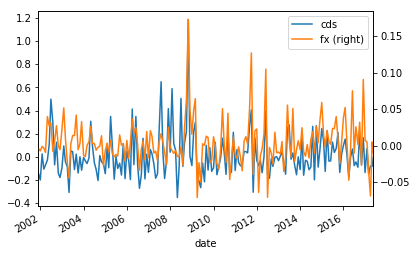

In [3]:
ret = df.pct_change()
ret = ret.dropna()
ret.cds.plot(label='cds',legend=True)
ret.fx.plot(secondary_y=True,label='fx',legend=True)
plt.show()

In [4]:
cds = ret.cds
fx = ret.fx
cds_val = df.cds
fx_val = df.fx
cds_val_diff= df.cds.diff(1).dropna()
fx_val_diff = df.fx.diff(1).dropna()

In [5]:
#ADF test
adf_cds = sm.tsa.adfuller(cds_val)
adf_fx = sm.tsa.adfuller(fx_val)
adf_cds,adf_fx

((-3.3806863577352972,
  0.011635159145565835,
  4,
  183,
  {'1%': -3.4665980802684251,
   '10%': -2.5752604356654425,
   '5%': -2.8774669520682674},
  1600.9896091686053),
 (-0.3201024172937304,
  0.92260857993194334,
  0,
  187,
  {'1%': -3.465811691080702,
   '10%': -2.5750770662586864,
   '5%': -2.8771233514726489},
  204.30279930493117))

In [6]:
model = sm.OLS(cds_val,sm.add_constant(fx_val)).fit(cov_type='HC0')

In [7]:
resid = model.resid
coint = cds_val - model.params[1]*fx_val
adf_resid = sm.tsa.adfuller(coint)


In [8]:
vecm_cds = sm.OLS(cds_val_diff[1:],np.c_[coint[1:-1],cds_val_diff[:-1],fx_val_diff[:-1]]).fit(cov_type="HC0")
vecm_fx = sm.OLS(fx_val_diff[1:],np.c_[coint[1:-1],cds_val_diff[:-1],fx_val_diff[:-1]]).fit(cov_type="HC0")
print(vecm_cds.summary())
print(vecm_fx.summary())

                            OLS Regression Results                            
Dep. Variable:                    cds   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.773
Date:                Wed, 17 May 2017   Prob (F-statistic):              0.154
Time:                        18:09:24   Log-Likelihood:                -883.11
No. Observations:                 186   AIC:                             1772.
Df Residuals:                     183   BIC:                             1782.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0389      0.027     -1.417      0.1

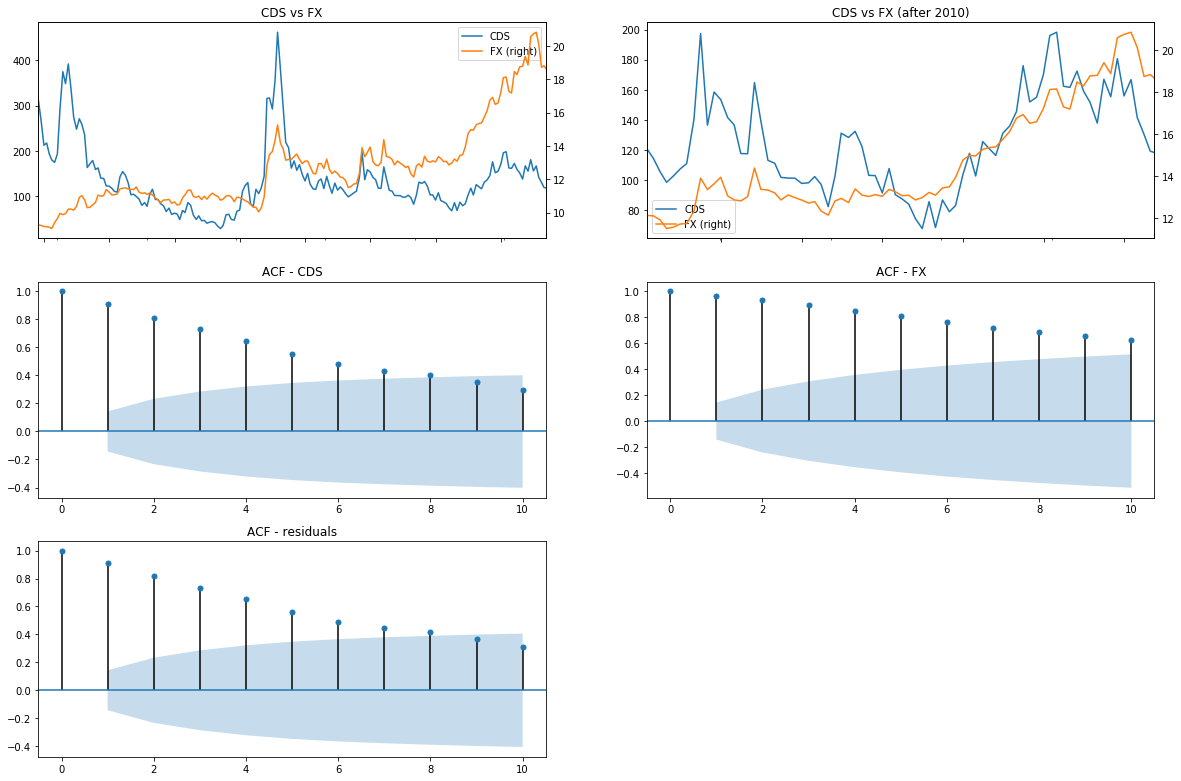

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

fig.delaxes(ax[-1,-1]) 
ax[0][0].set_title('CDS vs FX')
df.cds.plot(label='CDS',legend=True,ax=ax[0][0])
df.fx.plot(secondary_y=True,label='FX',legend=True,ax=ax[0][0])

ax[0][1].set_title('CDS vs FX (after 2010)')
df.cds[(df.index.year)>2010].plot(label='CDS',legend=True,ax=ax[0][1])
df.fx[(df.index.year)>2010].plot(secondary_y=True,label='FX',legend=True,ax=ax[0][1])


sm.graphics.tsa.plot_acf(cds_val,ax=ax[1][0],lags=10)
ax[1][0].set_title('ACF - CDS')


sm.graphics.tsa.plot_acf(fx_val,ax=ax[1][1],lags=10)
ax[1][1].set_title('ACF - FX')


sm.graphics.tsa.plot_acf(resid,ax=ax[2][0],lags=10)
ax[2][0].set_title('ACF - residuals')


plt.savefig('CDSFX.png')
plt.show()
